# Preprocesamiento

En esta etapa se toman decisiones en línea con las estadísticas y análisis con tal de  preparar correctamente los datos que serán parte del entrenamiento y posterior validación de los modelos de predicción.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nilmtk import DataSet
import warnings
from nilmtk import TimeFrame
warnings. filterwarnings("ignore")
plt.style.use('bmh')



In [2]:
#dataset de referencia DSUALM
deps = DataSet('dsual.h5')

elec=deps.buildings[1].elec # Todos los medidores

labels = pd.DataFrame({'Instances': list(range(1,8)),
                       'Meters': ['Main', 'Boliler', 'Fan', 'Freezer', 'Television','Vacuum Cleaner', 'Light']})
Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]

## Cambio en el muestreo de datos e interpolación

### Ejemplo seccion faltante

In [3]:
tf=elec[1].good_sections(full_results=True).combined()[0]
tf

TimeFrame(start='2021-11-10 18:08:48+01:00', end='2021-11-10 20:49:17+01:00', empty=False)

Muestreo cada 10 segundos, promediando datos

In [4]:
ta = '2021-11-10 19:08:00+01:00'
tb = '2021-11-10 19:08:10+01:00'


#ta = '2021-11-10 18:08:48+01:00'
#tb = '2021-11-10 20:49:17+01:00'
next(elec[1].load(sample_period=10, resample_kwargs={'fill_method':'ffill', 'how': 'mean'}))[ta:tb]

physical_quantity,power,current,power,frequency,power,voltage,pf
type,apparent,,active,,reactive,,
2021-11-10 19:08:00+01:00,1668.884521,6.950351,846.258423,50.016083,-1438.409424,240.230286,0.506837
2021-11-10 19:08:10+01:00,1669.601807,6.951946,846.420532,50.004089,-1439.146362,240.280655,0.506712


Muestreo cada 10 segundos, usando el primer dato

In [5]:
ta = '2021-11-10 19:08:00+01:00'
tb = '2021-11-10 19:08:10+01:00'
next(elec[1].load(sample_period=10, resample_kwargs={'fill_method':'ffill', 'how': 'first'}))[ta:tb]

physical_quantity,power,current,power,frequency,power,voltage,pf
type,apparent,,active,,reactive,,
2021-11-10 19:08:00+01:00,1668.857666,6.949212,846.608398,50.020119,-1438.171997,240.265594,0.507055
2021-11-10 19:08:10+01:00,1668.918335,6.950228,845.807617,50.009399,-1438.713989,240.240402,0.506555


## Filtros de dispositivos eléctricos

In [7]:
Devices=elec.select(instance=[2,3,4,5,6,7]) #MeterGroup de dispositivos
d=Devices.energy_per_meter().loc['active']  # seleccionamos potencia activa
d[d>10] #filtramos para  dispositivos mayores que 10W
d

6/6 ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])ance=1)])

(2, 1, DSUAL)    0.068263
(3, 1, DSUAL)    0.001876
(4, 1, DSUAL)    0.003843
(5, 1, DSUAL)    0.000264
(6, 1, DSUAL)    0.038443
(7, 1, DSUAL)    0.000247
Name: active, dtype: float64

*top-k*

In [15]:
Devices = elec.select(instance=[2,3,4,5,6,7])
Devices.select_top_k(k=5)

6/6 ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])ance=1)])

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
)

## División del dataset

- train: conjunto de datos de entrenamiento de modelos de desagregación
- test: conjunto de datos de validación y pruebas de modelos de desagregación

Entrenamiento:

In [9]:
train = DataSet('dsual.h5')

#train.set_window(start="2021-11-11 17:39:00", end="2021-11-11 17:40:00")
train.set_window(start="2021-11-10 18:08:00", end="2021-11-10 20:49:00")

train_elec=train.buildings[1].elec

train_elec.get_timeframe()

TimeFrame(start='2021-11-10 18:08:48+01:00', end='2021-11-10 20:49:00+01:00', empty=False)

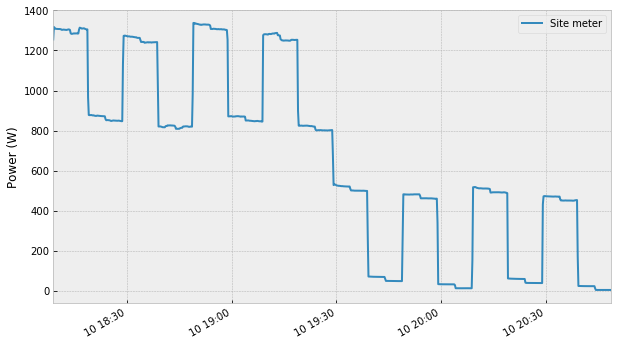

In [10]:
train_elec.plot()
#no hay datos train_elec.submeters().plot()



Validación:

In [11]:
 #Validación 

valid = DataSet('dsual.h5')

#valid.set_window(start="2021-11-10 18:08:00", end="2021-11-10 20:00:00")
valid.set_window(start="2021-11-10 18:08:00", end="2021-11-10 20:00:00")
valid_elec=valid.buildings[1].elec

valid_elec.get_timeframe()

TimeFrame(start='2021-11-10 18:08:48+01:00', end='2021-11-10 20:00:00+01:00', empty=False)

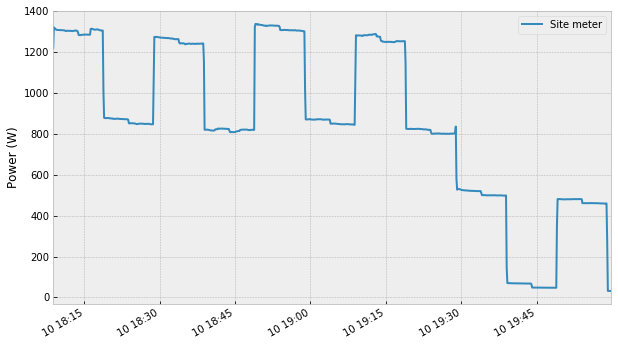

In [12]:
valid_elec.mains().plot()
valid_elec.submeters().plot()

Pruebas

In [13]:


#test=DataSet('C:/data/DEPS.h5') #Pruebas

test = DataSet('dsual.h5')

test.set_window(start="2021-11-10 20:00:00", end="2021-11-10 20:50:00")
test_elec=test.buildings[1].elec

test_elec.get_timeframe()

TimeFrame(start='2021-11-10 20:00:00+01:00', end='2021-11-10 20:49:17+01:00', empty=False)

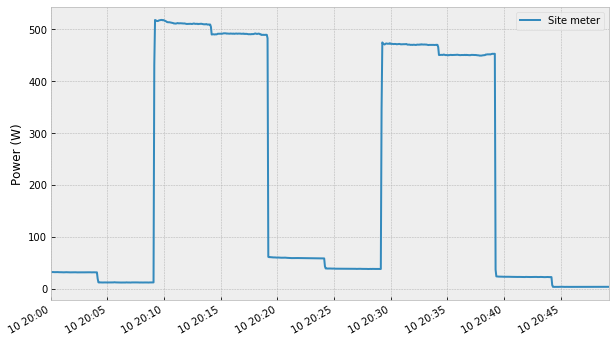

In [14]:
test_elec.mains().plot()